In [ ]:
from typing import TypedDict, List, Optional

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
# Define the LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [5]:
# Define system prompt
SYSTEM_PROMPT = """You are a helpful assistant.
"""

In [12]:
# Define the state with short-term memory
class State(TypedDict):
    question: str
    response: Optional[str]
    chat_history: List[BaseMessage]

In [13]:
def initialize_state() -> State:
    """Initialize the agent state with empty chat history."""
    return {
        "question": "",
        "response": None,
        "chat_history": [SystemMessage(content=SYSTEM_PROMPT)]
    }

In [14]:
# Define the agent function
def agent(state: State) -> State:
    """Process the user question and update the chat history."""
    # Get current question and chat history
    question = state["question"]
    chat_history = state["chat_history"]
    
    # Add the new question to the chat history
    chat_history.append(HumanMessage(content=question))
    
    # Get response from the LLM
    response = llm.invoke(chat_history)
    
    # Add the response to chat history
    chat_history.append(response)
    
    # Return updated state
    return {
        "question": question,
        "response": response.content,
        "chat_history": chat_history
    }

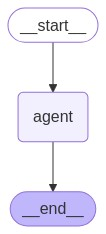

In [15]:
# Create the graph
workflow = StateGraph(State)
workflow.add_node("agent", agent)
workflow.set_entry_point("agent")
workflow.add_edge("agent", END)

# Compile the graph
graph = workflow.compile()

# Display the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

### Simulate a conversation

In [16]:
# Example conversation with references to previous questions
questions = [
    "My name is Alex. What's the weather like today?",
    "Can you remember my name?",
    "What was my first question about?",
    "Tell me about machine learning."
]

In [17]:
# Function to simulate a conversation
def simulate_conversation(graph, questions: List[str]):
    """Simulate a conversation with multiple questions."""
    print("Starting conversation with short-term memory...\n")
    
    # Initialize state
    state = initialize_state()
    
    for i, question in enumerate(questions):
        print(f"Turn {i+1}:")
        print(f"User: {question}")
        
        # Update the question in the state
        state["question"] = question
        
        # Run the graph
        result = graph.invoke(state)
        
        # Update the state for the next turn
        state = result
        
        print(f"Assistant: {result['response']}")
        print("\n" + "-"*50 + "\n")
    
    print("Conversation ended. If we start a new conversation, the memory will be reset.")
    return state

In [18]:
# Run the conversation
final_state = simulate_conversation(graph, questions)

for message in final_state["chat_history"]:
    role = message.type
    print(f"{role}: {message.content}")

Starting conversation with short-term memory...

Turn 1:
User: My name is Alex. What's the weather like today?
Assistant: I'm sorry, Alex, but I don't have real-time weather data. You can check a weather website or app for the most accurate and up-to-date information on today's weather. If you tell me your location, I can suggest how to find the weather for your area!

--------------------------------------------------

Turn 2:
User: Can you remember my name?
Assistant: I can remember your name, Alex, for the duration of our conversation. However, I won't be able to recall it in future interactions. Each session is independent, so if you start a new conversation, you'll need to tell me your name again. How can I assist you today, Alex?

--------------------------------------------------

Turn 3:
User: What was my first question about?
Assistant: Your first question was about the weather today. You asked, "What's the weather like today?" If you have any other questions or need assistanc

### Short Term Memory reset

In [19]:
# Start a new conversation (memory reset)
new_questions = [
    "Do you remember my name?",
    "I'm Taylor. Can you remember that?",
    "What's my name now?"
]

new_state = simulate_conversation(graph, new_questions)

Starting conversation with short-term memory...

Turn 1:
User: Do you remember my name?
Assistant: I don't have the ability to remember personal information or previous interactions, including your name. Each session is independent, so I don't retain any details once our conversation ends. How can I assist you today?

--------------------------------------------------

Turn 2:
User: I'm Taylor. Can you remember that?
Assistant: I can't remember personal information like your name from one interaction to the next. However, I can use your name, Taylor, during our current conversation. How can I assist you today?

--------------------------------------------------

Turn 3:
User: What's my name now?
Assistant: Your name is Taylor. How can I help you today, Taylor?

--------------------------------------------------

Conversation ended. If we start a new conversation, the memory will be reset.
